In [1]:
#import standard libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy
import datetime
import os
import time

#Import Personal Libraries
import io_utils3 as io_utils
import work_utils as unwrapper

#     File Paths

# Unprocessed RISR-N HDF5 Files
datadir = '/data/plutus/AMISR/RISRN/processed/'

# IRI and ECHAIM models for comparison
model_outputs_path = '/home/mlundqui/Ionosphere_Models_20250715'

# Fitted Data
fitted_data_path = '/home/mlundqui/RecentOutputs_20250715'

AE_path = '/home/mlundqui/Ionosphere_Models_20250715/Proxy_AE'



In [2]:
years = []
minutes_by_years_array = np.column_stack((np.arange(2009,2026), np.zeros_like(np.arange(2009,2026))))

for filename in os.listdir(datadir):
    f = os.path.join(datadir, filename)
    if os.path.isfile(f) == True:
        if filename[0] == '2' and filename[16:18] == '1m' and filename.count('.') != 3 and 'fullchem' not in filename:
            years.append(filename)
            if filename == '20191228.001_lp_1min-fitcal.h5': # Only exp that crosses the year boundary, precalcuated minutes of data
                minutes_by_years_array[-1, 1] += (2618.0666666666666/60)
                minutes_by_years_array[-2, 1] += (5753.466666666666/60)
                continue

            flp = io_utils.read_partial_h5file(os.path.join(datadir, filename), '/Time')
            datetime_array = [datetime.datetime(1970,1,1)+datetime.timedelta(seconds=int(t)) for t in flp['/Time']['UnixTime'][:,0]]
            year_index = datetime_array[0].year - 2009
            mins = (datetime_array[-1]-datetime_array[0]).total_seconds()/(60*60)
            minutes_by_years_array[year_index, 1] += mins
   
                
                

In [3]:
years = []
hours_by_years_array = np.zeros((len(np.arange(2009,2026)), 12))

for filename in os.listdir(datadir):
    f = os.path.join(datadir, filename)
    if os.path.isfile(f) == True:
        if filename[0] == '2' and filename[16:18] == '1m' and filename.count('.') != 3 and 'fullchem' not in filename:
            years.append(filename)
            if filename == '20191228.001_lp_1min-fitcal.h5': # Only exp that crosses the year boundary, precalcuated minutes of data
                #minutes_by_years_array[-1, 1] += (2618.0666666666666/60)
                #minutes_by_years_array[-2, 1] += (5753.466666666666/60)
                hours_by_years_array[2019-2009][11] += (2618.0666666666666/60)
                hours_by_years_array[2020-2009][0] += (5753.466666666666/60)
                continue

            flp = io_utils.read_partial_h5file(os.path.join(datadir, filename), '/Time')
            datetime_array = [datetime.datetime(1970,1,1)+datetime.timedelta(seconds=int(t)) for t in flp['/Time']['UnixTime'][:,0]]
            for step in range(len(datetime_array)):
                if step == 0:
                    continue
                year_index = datetime_array[step].year - 2009
                month_index = datetime_array[step].month-1
                hours_by_years_array[year_index][month_index] += (datetime_array[step]-datetime_array[step-1]).total_seconds()/(60*60)
                
            
            

In [4]:
hours_by_years_array_masked = np.array(hours_by_years_array)
hours_by_years_array_masked[hours_by_years_array==0] = np.nan


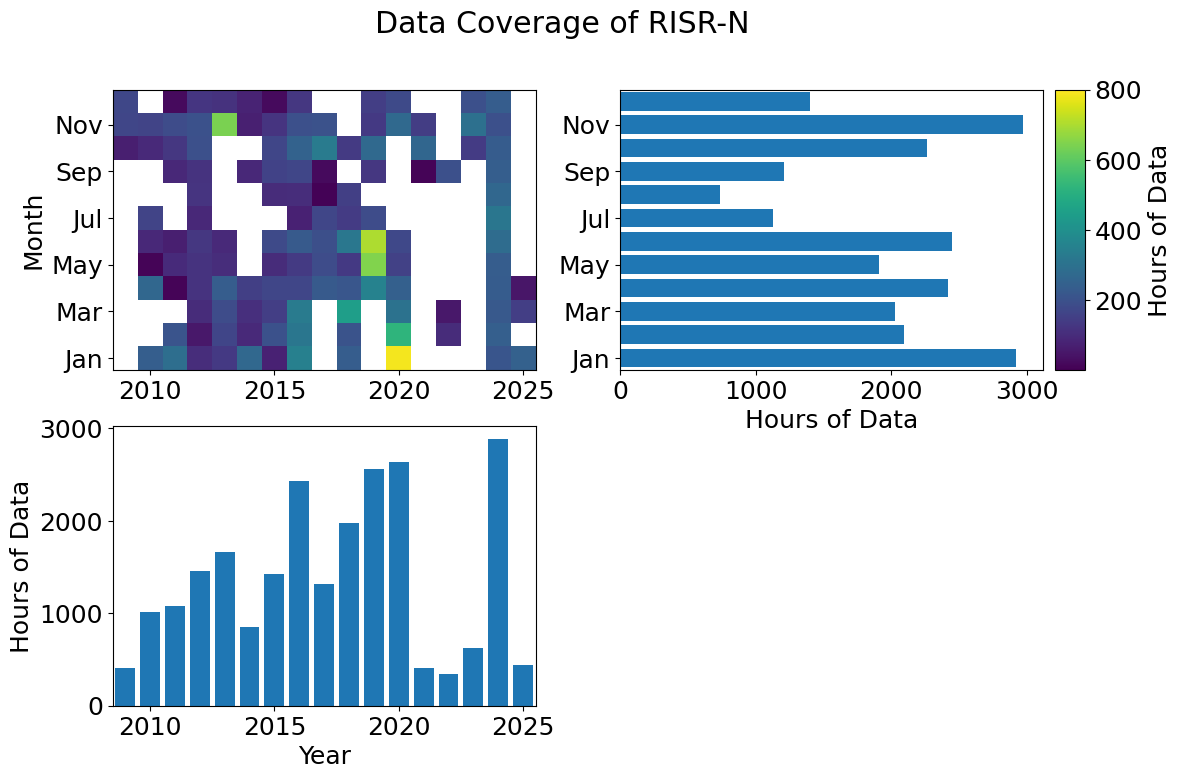

In [5]:
plt.rcParams['figure.figsize']=12,8
plt.rcParams['font.size']=18
fig,axarr = plt.subplots(2,2)
#fig.subplots_adjust(hspace=0.4)
#plt.subplots_adjust(wspace=0.5)

neclrs=axarr[0,0].pcolormesh(np.arange(2009,2026),[str(datetime.date(2010, i, 2).strftime('%b')) for i in range(1,13)],hours_by_years_array_masked.T, vmin=0.01,vmax=800)
axarr[0,0].set_ylabel('Month')
axarr[1,0].set_xlabel('Year')
axarr[0,0].set_yticks([str(datetime.date(2010, i, 2).strftime('%b')) for i in range(1,13,2)])
box2=axarr[0,1].get_position()
cbarax2=fig.add_axes([box2.x0+box2.width+0.01, box2.y0, 0.025, box2.height])
cb2=plt.colorbar(neclrs,cax=cbarax2)
cb2.set_label(r'Hours of Data')

months = np.array([np.sum(hours_by_years_array[:,j]) for j in range(0,12)])
axarr[0,1].barh([str(datetime.date(2010, i, 2).strftime('%b')) for i in range(1,13)],months)
axarr[0,1].set_xlabel('Hours of Data')
axarr[0,1].set_yticks([str(datetime.date(2010, i, 2).strftime('%b')) for i in range(1,13,2)])

years = np.array([np.sum(hours_by_years_array[j,:]) for j in range(0,17)])
axarr[1,0].bar(np.arange(2009, 2026), years)
axarr[1,0].set_ylabel('Hours of Data')
axarr[1,0].sharex(axarr[0,0])
axarr[0,1].sharey(axarr[0,0])

fig.delaxes(axarr[1,1])
fig.suptitle('Data Coverage of RISR-N')

plt.savefig('DataCoverage.png', format='png', dpi=660, bbox_inches='tight')